In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the below cell, we import all necessary Python libraries used throughout the project:

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
base_dir = "/content/drive/MyDrive/intel_cv_project/dataset"

The dataset is organized into separate folders for training and testing.  
Here, we define the directory paths and confirm that the folders are correctly detected by the notebook:


In [4]:
train_dir = os.path.join(base_dir, "seg_train", "seg_train")
test_dir  = os.path.join(base_dir, "seg_test", "seg_test")

print("Train dir exists:", os.path.isdir(train_dir))
print("Test dir exists:", os.path.isdir(test_dir))

Train dir exists: True
Test dir exists: True


## Loading Images and Creating Train/Validation Sets

Now that we’ve confirmed our dataset is in the right place, we can actually load the images into TensorFlow.

I’m using `image_dataset_from_directory` because it does a lot of the heavy lifting for us:
- It reads images straight from the folder structure and automatically assigns labels based on folder names.
- Splits the training data into **80% training** and **20% validation**
- Resizes everything to the same image size and organizes the data into batches for faster training

Once the data is loaded, I print out the class names , just to double-check that TensorFlow picked up all categories correctly before we move ahead.


Now lets see why image size = (150, 150)?

We resize every image to 150×150 pixels because:

* It keeps input dimensions consistent for the neural network
* It’s large enough to capture useful image features and small enough to train quickly on a normal laptop/GPU

Higher resolutions (224×224, 299×299) may improve accuracy but increase training time and GPU memory.

So 150×150 is a great balance between performance and speed.

In [5]:
img_size = (150, 150)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2,subset="training",seed=42,image_size=img_size,batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2, subset="validation", seed=42, image_size=img_size, batch_size=batch_size)

class_names = train_ds.class_names

print("Classes:", class_names)


Found 14035 files belonging to 6 classes.
Using 11228 files for training.
Found 14035 files belonging to 6 classes.
Using 2807 files for validation.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## A Quick Look at the Training Images

Before we start training the model, I wanted to visually check a few samples from the dataset.

This helps confirm that, Images are loading correctly and Labels match the right categories


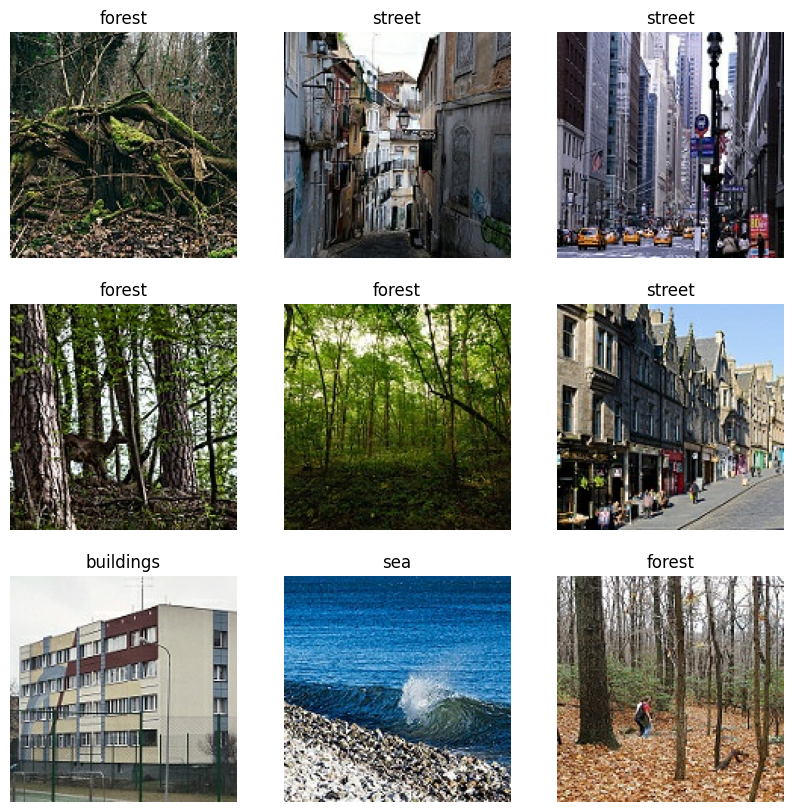

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

 Everything looks good , so we’re ready to move forward!


## Preparing the Data Pipeline for Faster Training

Neural networks train a lot faster when the input pipeline is optimized, so instead of feeding images “as is,” I added a few improvements:

**Normalization:**  
Pixel values are scaled from `[0–255]` down to `[0–1]`.  

**Shuffling (only for training data):**  
This prevents the model from memorizing the order of images.

**Caching + Prefetching:**  
These two work together to make data loading super efficient:
- `cache()` keeps previously-seen images ready in memory
- `prefetch()` overlaps data processing with model training

Result: The GPU never sits idle waiting for images , everything flows smoothly

We wrap it all inside a simple `prepare()` function so the code stays clean.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds   = prepare(val_ds, shuffle=False)


## Building a Baseline Convolutional Neural Network (CNN)

 I wanted to start with a simple baseline model to understand how well a basic CNN performs on this dataset.

This model includes:

A few **Conv2D + MaxPool** layers to extract visual features.

A **Flatten + Dense** layer to learn class patterns  

**Dropout** to reduce overfitting  

A final **softmax** layer to output class probabilities  

Nothing fancy yet , just a solid first attempt that gives us a performance benchmark.  

Once we train this CNN, we'll compare it later with a pre-trained model (MobileNetV2) to see how much transfer learning improves results.

In [8]:
num_classes = len(class_names)

model = keras.Sequential([
    layers.Input(shape=img_size + (3,)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

##  Training the Baseline CNN Model

Now that the baseline CNN is ready, it’s time to train it!  
I started with **10 epochs** just to get a quick sense of how well this simple model perform.

During training, we'll be tracking:
1. **Training accuracy**
2. **Validation accuracy**

This helps us understand whether the model is learning useful features or just memorizing the training data.

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2367s 1s/step - accuracy: 0.4437 - loss: 1.3965 - val_accuracy: 0.6195 - val_loss: 0.9833
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6514 - loss: 0.9028 - val_accuracy: 0.7581 - val_loss: 0.7023
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7509 - loss: 0.6998 - val_accuracy: 0.7802 - val_loss: 0.6336
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8015 - loss: 0.5755 - val_accuracy: 0.7987 - val_loss: 0.5877
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8290 - loss: 0.4947 - val_accuracy: 0.8044 - val_loss: 0.5692
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8509 - loss: 0.4157 - val_accuracy: 0.8301 - val_loss: 0.5630
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8697 - loss: 0.3655 - val_accuracy: 0.8326 - val_loss: 0.5764
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8906 - loss: 0.3070 - val_acc

The baseline CNN steadily improved during training and reached around **81–82% validation accuracy**, which is a solid starting point.  

However, the growing gap between training and validation accuracy suggests **overfitting**, meaning the model is starting to memorize the training data.

## Visualizing Training Performance

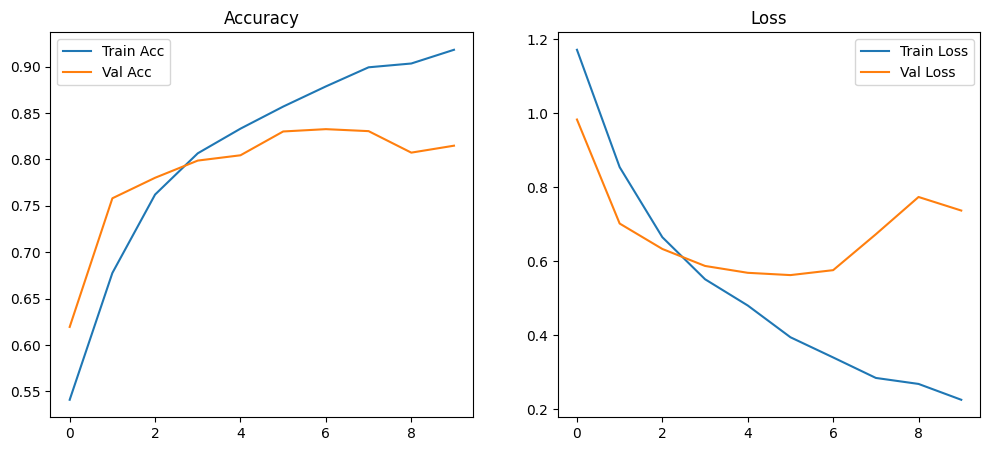

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


Classification report:
              precision    recall  f1-score   support

   buildings       0.79      0.78      0.79       430
      forest       0.92      0.98      0.95       436
     glacier       0.81      0.70      0.75       474
    mountain       0.74      0.81      0.77       514
         sea       0.79      0.82      0.80       477
      street       0.86      0.80      0.83       476

    accuracy                           0.81      2807
   macro avg       0.82      0.82      0.82      2807
weighted avg       0.82      0.81      0.81      2807


Confusion matrix:
[[336  10   5  19  10  50]
 [  3 429   1   1   0   2]
 [  9   2 330  79  50   4]
 [  0   3  52 417  39   3]
 [ 12   6  16  47 392   4]
 [ 64  14   5   2   8 383]]


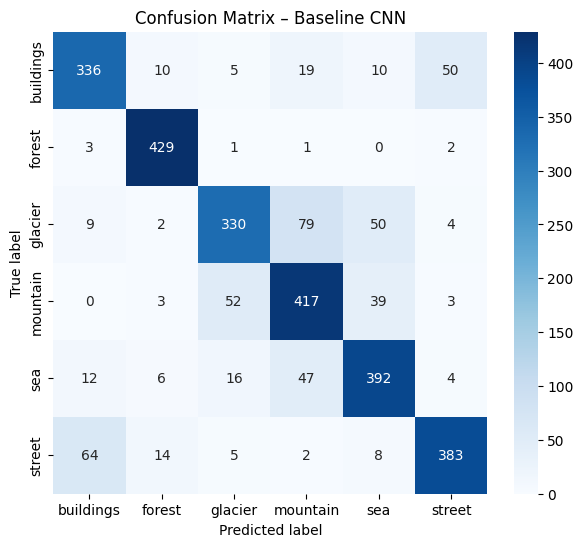

In [11]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

#confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline CNN")
plt.show()


Before switching to a more advanced model, I wanted to actually see how well the baseline CNN is predicting. Below, I show **9 random validation images** along with:

The **true label** (ground truth) and **predicted label** from our model

This gives a quick visual check of:
- whether predictions generally make sense
- which classes are more confusing for the model right now



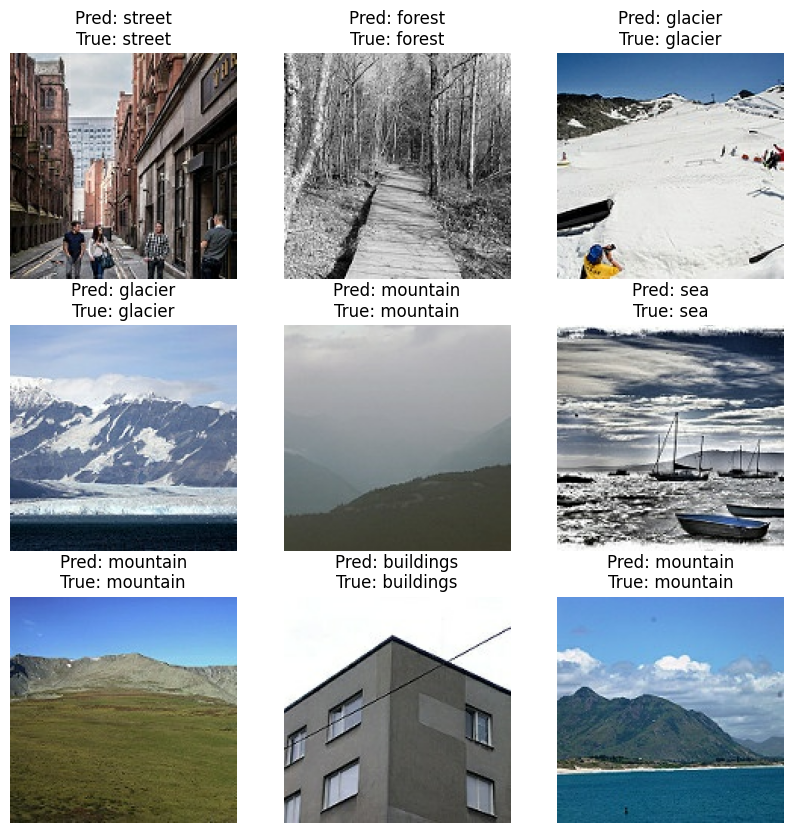

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):

    images_to_show = images.numpy().astype("float32")


    if images_to_show.max() <= 1.0:
        images_to_show = images_to_show * 255.0

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        img = images_to_show[i].astype("uint8")

        preds = model.predict(images[i:i+1], verbose=0)
        pred_class = class_names[np.argmax(preds[0])]
        true_class = class_names[labels[i]]

        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")


Predictions are correct ,which is great!  
But there are also a few mistakes, which lines up with the ~81% validation accuracy we saw earlier.

Now we know exactly where we stand , so time to level up with MobileNetV2 and see how much improvement transfer learning brings!

## Transfer Learning with MobileNetV2

Now that we’ve learned what a simple baselinw CNN can do, it's time to upgrade.  
To boost accuracy and reduce overfitting, I used **MobileNetV2**, a pre-trained model originally trained on **ImageNet** (1.4M images, 1000 classes).

Why MobileNetV2?

Because it is fast  and it already learned general image features like edges, textures, shapes. Therefore, we only need to teach it features specific to our dataset

### What I did here:
- Loaded MobileNetV2 **without its classification head**
- **Froze** the pretrained layers so they don’t get destroyed during training
- Added my own custom classifier:
  - Global Average Pooling
  - Dense layer with ReLU activation
  - Dropout for regularization
  - Final softmax layer for predictions

This helps the model keep all its “smart” ImageNet knowledge while still adapting to our new classes.


In [13]:
base_model = MobileNetV2(
    input_shape=(150,150,3),
    include_top=False,
    weights='imagenet'
)

#freeze pretrained layers
base_model.trainable = False

#classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/tmp/ipython-input-697872831.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

With our transfer learning setup ready, I fine-tuned the model for **10 epochs** using the same training and validation datasets as before.

Since MobileNetV2 already has strong feature extraction capabilities, it should learn faster and generalize better than our baseline CNN , and ideally, we should see a **big jump** in validation accuracy with reduced overfitting.


In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7824 - loss: 0.6119 - val_accuracy: 0.8885 - val_loss: 0.2928
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8990 - loss: 0.2814 - val_accuracy: 0.8953 - val_loss: 0.2774
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9083 - loss: 0.2484 - val_accuracy: 0.9027 - val_loss: 0.2636
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9193 - loss: 0.2164 - val_accuracy: 0.9052 - val_loss: 0.2668
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9295 - loss: 0.1927 - val_accuracy: 0.9088 - val_loss: 0.2642
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9300 - loss: 0.1810 - val_accuracy: 0.9017 - val_loss: 0.2779
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9410 - loss: 0.1609 - val_accuracy: 0.9063 - val_loss: 0.2733
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9382 - loss: 0.1552 - val_acc

MobileNetV2 achieved a **huge performance boost**, reaching ~90% validation accuracy within just a few epochs , a clear improvement over the baseline CNN.  
Even better, the gap between training and validation accuracy is much smaller, showing **better generalization and reduced overfitting** thanks to transfer learning.

## Visualizing Training Performance

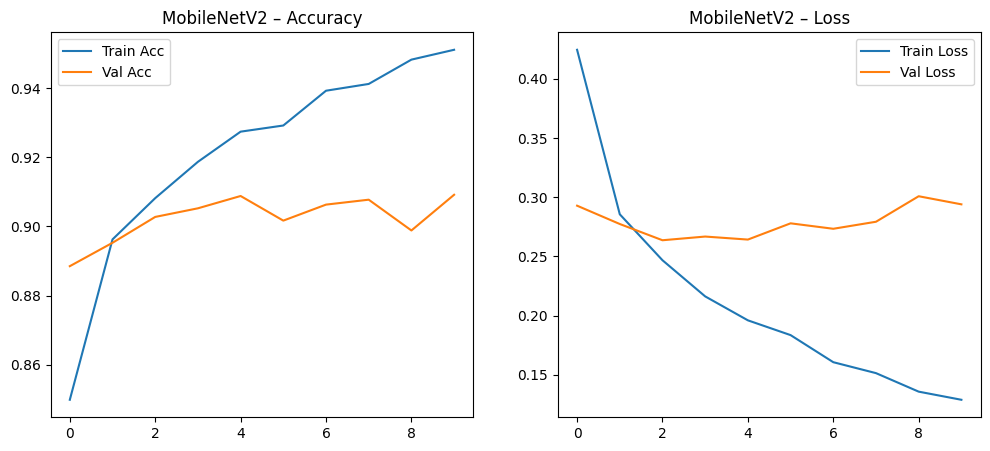

In [15]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.title("MobileNetV2 – Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.title("MobileNetV2 – Loss")
plt.legend()

plt.show()


Classification report (MobileNetV2):
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       430
      forest       0.99      1.00      0.99       436
     glacier       0.85      0.82      0.83       474
    mountain       0.84      0.86      0.85       514
         sea       0.94      0.95      0.94       477
      street       0.94      0.91      0.93       476

    accuracy                           0.91      2807
   macro avg       0.91      0.91      0.91      2807
weighted avg       0.91      0.91      0.91      2807



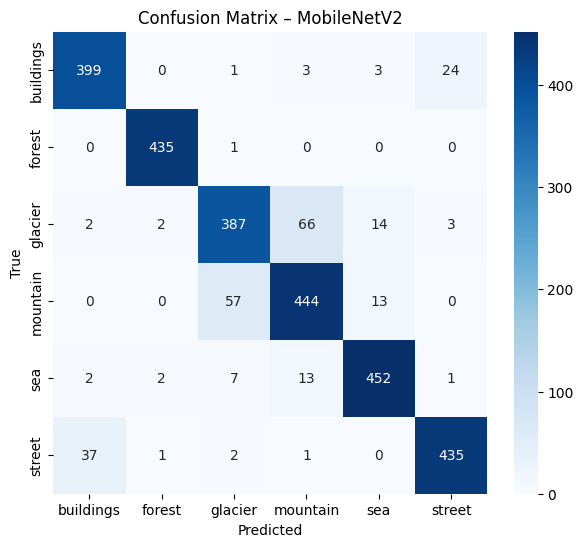

In [16]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report (MobileNetV2):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – MobileNetV2")
plt.show()


## Phase-2 Fine-Tuning: Unlocking More Layers

After the first round of training, MobileNetV2 already performed really well while its pretrained layers were frozen. But to squeeze out even more accuracy(especially for streets and building confusion), I partially **unfroze the base model** and fine-tuned more layers with a **very small learning rate**.

This stage is like giving the model a chance to “polish” its understanding without forgetting what it learned from ImageNet.

Fine-tuning for 5 more epochs should improve validation performance and reduce errors on tricky images.

In [17]:
#unfreeze the base MobileNetV2
base_model.trainable = True

#(Aggressive)fine-tune almost all layers, but keep the very early ones frozen
fine_tune_at = 50   # lower = more layers trained, higher = fewer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#keep BatchNorm layers frozen (they get unstable if retrained)
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
fine_tune_epochs = 5

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9466 - loss: 0.1386 - val_accuracy: 0.9138 - val_loss: 0.2711
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9639 - loss: 0.0981 - val_accuracy: 0.9134 - val_loss: 0.2786
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9715 - loss: 0.0828 - val_accuracy: 0.9124 - val_loss: 0.2986
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9739 - loss: 0.0690 - val_accuracy: 0.9163 - val_loss: 0.2861
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9822 - loss: 0.0547 - val_accuracy: 0.9145 - val_loss: 0.3140


With additional fine-tuning, the model continues improving while keeping validation performance strong, showing that MobileNetV2 is now learning features far more relevant to our dataset.

Overall, this phase reinforces how much **transfer learning + fine-tuning** can elevate performance compared to building a model from scratch.


## Visualizing Training Performance

Fine-tuned MobileNetV2 – last epoch:
Train acc: 0.9800498485565186
Val acc: 0.9144994616508484
Classification report (MobileNetV2 fine-tuned):
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       430
      forest       0.98      0.99      0.99       436
     glacier       0.89      0.81      0.85       474
    mountain       0.82      0.91      0.87       514
         sea       0.97      0.93      0.95       477
      street       0.92      0.93      0.93       476

    accuracy                           0.91      2807
   macro avg       0.92      0.92      0.92      2807
weighted avg       0.92      0.91      0.91      2807



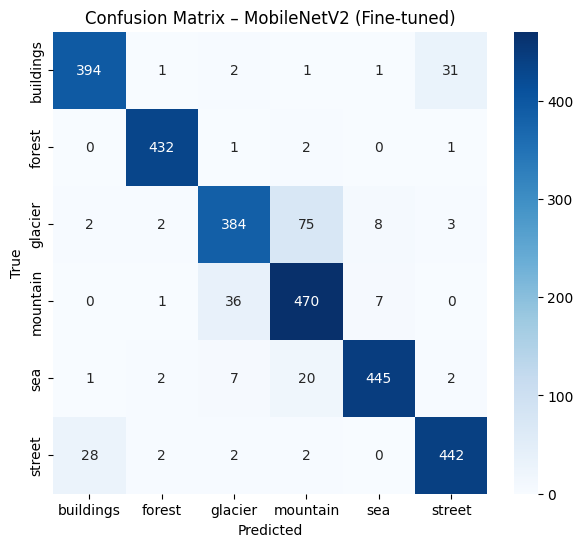

In [20]:
#accuracy / loss plots
acc_ft = history_fine.history["accuracy"]
val_acc_ft = history_fine.history["val_accuracy"]
loss_ft = history_fine.history["loss"]
val_loss_ft = history_fine.history["val_loss"]

print("Fine-tuned MobileNetV2 – last epoch:")
print("Train acc:", acc_ft[-1])
print("Val acc:", val_acc_ft[-1])

#classification report + confusion matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report (MobileNetV2 fine-tuned):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – MobileNetV2 (Fine-tuned)")
plt.show()


## Final training on the test dataset

In [21]:
#test dataset (labeled)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = prepare(test_ds_raw, shuffle=False)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.9089 - loss: 0.3112
Test accuracy: 0.9107
Test loss: 0.3006


              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       437
      forest       0.97      1.00      0.98       474
     glacier       0.89      0.79      0.83       553
    mountain       0.82      0.90      0.85       525
         sea       0.95      0.95      0.95       510
      street       0.92      0.95      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



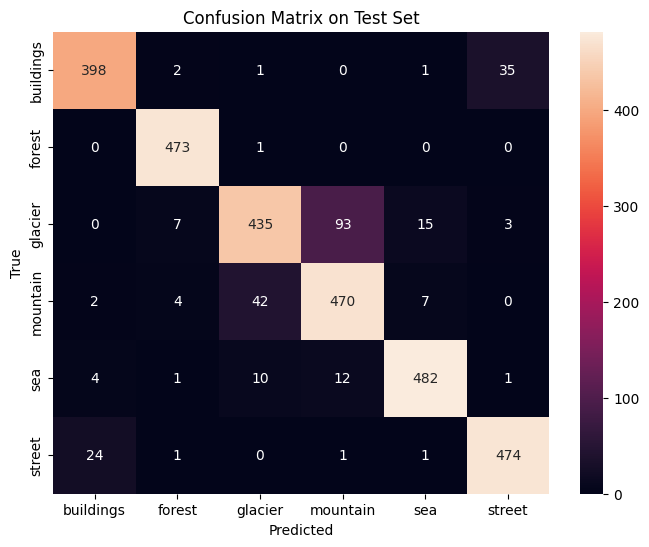

In [22]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#classification report
print(classification_report(y_true, y_pred, target_names=class_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.show()


With ~91% accuracy on the test set, the model demonstrates strong generalization ability and achieves performance comparable to other well-tuned transfer learning approaches on this dataset.

## Predicting on Completely Unlabeled Images (Real-World Simulation)

To see how the model performs in a real deployment scenario, I used the **prediction dataset** (`seg_pred`) that contains images **without labels**.

Since we do not know the true categories for these images, the goal here is to generate predictions using the trained MobileNetV2 model

Images are automatically organized into folders based on the predicted label and saved directly to Google Drive:



In [23]:
pred_dir = os.path.join(base_dir, "seg_pred", "seg_pred")

pred_ds_raw = tf.keras.utils.image_dataset_from_directory(
    pred_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    labels=None
)

pred_file_paths = pred_ds_raw.file_paths

pred_ds = pred_ds_raw.map(lambda x: (normalization_layer(x))).prefetch(AUTOTUNE)

pred_probs = model.predict(pred_ds)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [class_names[i] for i in pred_indices]

file_names = [os.path.basename(p) for p in pred_file_paths]

submission_df = pd.DataFrame({
    "filename": file_names,
    "predicted_label": pred_labels
})

submission_df.to_csv("submission.csv", index=False)
print("Saved predictions to submission.csv")
submission_df.head()


Found 957 files.
30/30 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
Saved predictions to submission.csv


,filename,predicted_label
0,10040.jpg,street
1,10043.jpg,sea
2,10054.jpg,mountain
3,10069.jpg,sea
4,10082.jpg,street


In [24]:
drive_output_dir = "/content/drive/MyDrive/intel_cv_project/predicted_output"
os.makedirs(drive_output_dir, exist_ok=True)

for img_path, label in zip(pred_file_paths, pred_labels):
    label_dir = os.path.join(drive_output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    filename = os.path.basename(img_path)
    dest_path = os.path.join(label_dir, filename)
    tf.io.gfile.copy(img_path, dest_path, overwrite=True)

print("Prediction images saved to Google Drive successfully! ")


Prediction images saved to Google Drive successfully! 
